In [378]:
import pandas as pd

columns_to_read = ["hrhhid", "hrhhid2", "peio1ocd", "ptdtrace", "hrhhid", "pulineno", "hrmonth", "gestfips", "pesex", "prtage", "peeduca", "peernlab"]
csv_files = ['../data/cpsb201801.csv', '../data/cpsb201804.csv', '../data/cpsb201808.csv', '../data/cpsb201812.csv', '../data/cpsb201901.csv', '../data/cpsb201904.csv', '../data/cpsb201908.csv', '../data/cpsb201912.csv']


dfs_18 = []
dfs_19 = []

for file in csv_files:
    if '2018' in file:
        df = pd.read_csv(file, usecols=columns_to_read)
        dfs_18.append(df)
    else: 
        df = pd.read_csv(file, usecols=columns_to_read)
        dfs_19.append(df)


combined_df_18 = pd.concat(dfs_18, ignore_index=True)
combined_df_19 = pd.concat(dfs_19, ignore_index=True)

combined_df_18.loc[combined_df_18['peio1ocd'] == '-1', 'pesex']

print(combined_df_18.head())
print(combined_df_19.head())



         hrhhid  hrmonth  hrhhid2  gestfips  prtage  pesex  peeduca  ptdtrace  \
0    4795110719        1     6011         1      71      1       42         1   
1    4795110719        1     6011         1      64      2       40         1   
2   71691004941        1     6111         1      72      1       40         1   
3   71691004941        1     6111         1      73      2       40         1   
4  110116792163        1     8011         1      66      1       43         1   

   pulineno  peernlab  peio1ocd  
0         1        -1        -1  
1         2        -1        -1  
2         1        -1      9140  
3         2        -1        -1  
4         1        -1      4920  
         hrhhid  hrmonth  hrhhid2  gestfips  prtage  pesex  peeduca  ptdtrace  \
0    4795110719        1     9011         1      68      1       38         2   
1    4795110719        1     9011         1      64      2       40         2   
2  110116792163        1     8011         1      -1     -1       -

In [237]:
import numpy as np

In [29]:
sex = combined_df_18.loc[combined_df_18['peio1ocd'] == -1, 'pesex']
age = combined_df_18.loc[combined_df_18['peio1ocd'] == -1, 'prtage']

(array([128077.,  56355.,  18545.,  10203.,   8893.,   9370.,  14741.,
         25022.,  32572.,  26285.]),
 array([-1. ,  7.6, 16.2, 24.8, 33.4, 42. , 50.6, 59.2, 67.8, 76.4, 85. ]),
 <BarContainer object of 10 artists>)

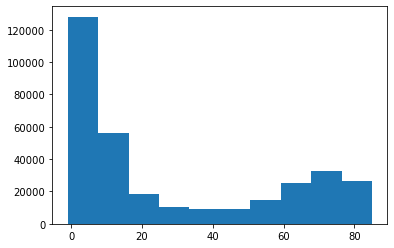

In [32]:
import matplotlib.pyplot as plt

#comparing the age distribution of the full sample and those who did not report an occupation. 
#They skew old and young which makes sense because they make up a solid portion of the unemployed population. 

plt.hist(combined_df_18['prtage'])


plt.hist(age)




In [379]:
#getting rid of all reponses which did not report an occupation 

df_18_filter = combined_df_18[combined_df_18['peio1ocd'] != -1]
df_19_filter = combined_df_19[combined_df_19['peio1ocd'] != -1]


#merging the data
#first need a concatination of hrhhid.1", "hrhhid2 which creates a unique identifier per respondent. 

#df_18_filter.loc[:, 'respondent_id'] = df_18_filter['hrhhid'] + df_18_filter['hrhhid2']
#df_19_filter.loc[:, 'respondent_id'] = df_19_filter['hrhhid'] + df_19_filter['hrhhid2']




In [380]:
transitions_df = pd.merge(df_18_filter, df_19_filter, on = ['pulineno', 'gestfips', 'pesex','ptdtrace', 'hrhhid', 'hrhhid2'], how = 'inner')

new_job = []
for job1, job2 in zip(transitions_df['peio1ocd_x'], transitions_df['peio1ocd_y']):
    if job1 != job2:
        new_job.append(1)
    else:
        new_job.append(0)

transitions_df['new_job'] = new_job
        
print(f"{sum(transitions_df['new_job'] == 1)/len(transitions_df) * 100}% of respondents reported a job change over the 1 year period")


37.811650802607545% of respondents reported a job change over the 1 year period


In [381]:
#different_rows = different_rows.reset_index(drop = True)

import numpy as np
def format_to_four_digits(value):
    value = int(value)
    num_digits = np.floor(np.log10(value) + 1) if value != 0 else 1  # Handle log10 for zero
    if num_digits == 2 or num_digits == 3:
        return f"{value:04d}"  
    return value

# Apply formatting function to each column
transitions_df['peio1ocd_x'] = transitions_df['peio1ocd_x'].apply(format_to_four_digits)
transitions_df['peio1ocd_y'] = transitions_df['peio1ocd_y'].apply(format_to_four_digits)

#change to string to ensure consistency with other datasets below

transitions_df['peio1ocd_x'] = transitions_df['peio1ocd_x'].astype(str)
transitions_df['peio1ocd_y'] = transitions_df['peio1ocd_y'].astype(str)



In [329]:
cen_soc_10 = pd.read_excel('../data/2010-occ-codes-with-crosswalk-from-2002-2011-1.xlsx', header = 0, skiprows = 4, names = ['', 'occupation', 'census', 'soc'])

/Users/lorenzogiamartino/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [340]:
#replace X's with the zeros they represent for merging
cen_soc_10['soc'] = cen_soc_10['soc'].astype(str).str.replace(r'XX', '00').str.replace(r'X', '0')

cen_soc_10['census'] = [x.strip() if isinstance(x, str) else x for x in cen_soc_10['census']]
cen_soc_10['soc'] = [x.strip() if isinstance(x, str) else x for x in cen_soc_10['soc']]

#get rid of na values 
cen_soc_10 = cen_soc_10[pd.isna(cen_soc_10['census']) == False]

#get rid of industry headers 
cen_soc_10 = cen_soc_10[~cen_soc_10['census'].str.contains('-', na = False)]

#
cen_soc_10['census'] = cen_soc_10['census'].astype(str)
cen_soc_10['soc'] = cen_soc_10['soc'].astype(str)


In [382]:
#mapping soc codes onto census codes in the CPS data

transitions_df['SOC_18'] = transitions_df['peio1ocd_x'].map(cen_soc_10.set_index('census')['soc'])
transitions_df['SOC_19'] = transitions_df['peio1ocd_y'].map(cen_soc_10.set_index('census')['soc'])


#no SOC code for census code 9840 for general military occupations so getting rid of these very few transitions. 
#Loosing 134686 - 132700 = 1986 observations. 

transitions_df = transitions_df[(transitions_df['peio1ocd_x'] != '4700') | (transitions_df['peio1ocd_y'] != '4700')]

In [367]:
wage_df = pd.read_excel('../data/national_M2018_dl.xlsx', usecols = ['OCC_CODE', 'A_MEAN', 'A_MEDIAN'])

#make sure occ codes are clean and of type str
wage_df['OCC_CODE'] = [x.strip() for x in wage_df['OCC_CODE'].astype(str)]

#master set of unique occupations in the transitions data 
occupations = set(transitions_df['SOC_18']).union(set(transitions_df['SOC_19']))

#the occupations which are not represented in the wage data 
[x for x in occupations if x not in list(wage_df['OCC_CODE'])]

#get rid of duplicates which exist for some reason 
wage_df = wage_df[~wage_df.duplicated(keep = 'first')]

In [383]:
#changing SOC codes "13-1021" "13-1022" "13-1023" to "13-1020" to comply with 2017 aggregation as discussed in appendix.

replacement = '13-1020'

codes_to_replace = ['13-1022', '13-1023', '13-1021']

transitions_df['SOC_18'] = [replacement if x in codes_to_replace else x for x in transitions_df['SOC_18']]
transitions_df['SOC_19'] = [replacement if x in codes_to_replace else x for x in transitions_df['SOC_19']]



In [399]:
#mapping income to the original data 

transitions_df['mean_wage_18'] = transitions_df['SOC_18'].map(wage_df.set_index('OCC_CODE')['A_MEAN'])
transitions_df['mean_wage_19'] = transitions_df['SOC_19'].map(wage_df.set_index('OCC_CODE')['A_MEAN'])




In [435]:
#now reading in ONET data 
dwa_df = pd.read_excel("../data/Tasks to DWAs.xlsx", usecols = ['O*NET-SOC Code', 'DWA Title'], dtype={'O*NET-SOC Code': str})
dwa_df.rename(columns={'O*NET-SOC Code': 'onet', 'DWA Title': 'dwa'}, inplace=True)
dwa_df['bool'] = 1




In [436]:
#creating crosswalk from SOC to ONET data 
dwa_df['onet'] = [x.strip() for x in dwa_df['onet']]






In [437]:
dwa_df['onet'][0][-4]

'1'

In [420]:
all_occupations = set(transitions_df['SOC_18']).union(set(transitions_df['SOC_19']))

In [421]:
crosswalk_dict = {'onet': [], 'soc': []}
for i, code in enumerate(dwa_df['onet']):
    if code[8:] == '00':
        crosswalk_dict['onet'].append(code)
        crosswalk_dict['soc'].append(code[:7])
    if code[-1] == '9':
        
        
        
        crosswalk_dict['onet'].append(code)
        crosswalk_dict['soc'].append(code[:7])
        
  
        
        
for i, code in enumerate(all_occupations):
    if code[-1] == '9':
        [x for x in dwa_df['onet'] if x[-4] == code]
        
        
        
        

TypeError: 'float' object is not subscriptable

In [439]:
for i, code in enumerate(all_occupations):
    print(i)
    print(code)
    if code[-1] == '9':
        [x for x in dwa_df['onet'] if x[-4] == code]

0
nan


TypeError: 'float' object is not subscriptable

In [443]:
sum(transitions_df['SOC_19'] == 'nan')

0